# Lab 1

## Task 9

## Reporter: Polyakov Gregory

### Description
Visualize KDE with KNN depending on neighbour number using interactive plots.

In [3]:
from ipywidgets import interact

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

import scipy.stats as sps

### Dataset:

Let's firstly build the dataset manually so that we could better visualize KDE

Let's take several samples from Gumbel distribution with different hyperparameters

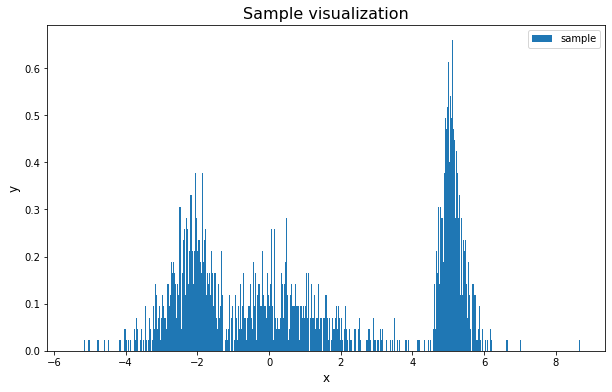

In [6]:
%matplotlib inline
sample_1 = sps.gumbel_r.rvs(size=1000)
sample_2 = sps.gumbel_l.rvs(loc=-2, scale=1/2, size=1000)
sample_3 = sps.gumbel_r.rvs(loc=5, scale=1/4, size=1000)
data = np.concatenate((sample_1, sample_2, sample_3))

plt.figure(figsize=(10, 6))
plt.hist(data, density=True, bins=1000, label='sample')
plt.title('Sample visualization', fontsize=16)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.show()

### KDE with KNN

$X$ - sample from an unknown distribution, $N = |X|$

$K$ - kernel estimator

We'll take simple Gaussian estimator
$$K(x) = \rho_{\mathcal{N}\left(\overline{0}, I\right)}(x)$$

Estimated density:

$$p(x) = \frac{1}{N} \cdot \sum_{x_i \in X} \frac{1}{h_i} K\left(\frac{x - x_i}{h_i}\right)$$

where $h_i$ - distance between $x_i$ and k-th nearest neighbour of $x_i$ in $X$ 

In [7]:
def kernel(x):
    return sps.norm.pdf(x)

def kde_with_knn(x, data, distances, neighb_num):
    # compute distances to k-th nearest neighbor from all data points
    k_distances = distances[:, neighb_num+1]
    
    # compute kernel estimator inputs ((x - x_i) / h_i)
    kernel_input = x.reshape((-1, 1)) - data.reshape((1, -1))
    kernel_input /= k_distances
    
    kernel_values = kernel(kernel_input)
    kernel_values /= k_distances * data.shape[0]
    
    return kernel_values.sum(axis=-1).flatten()

Implementation of "naive" KDE to compare it with our method:

$$p(x) = \frac{1}{N} \cdot \sum_{x_i \in X} \frac{1}{h} K\left(\frac{x - x_i}{h}\right)$$

In [10]:
def kde(x, data, h):    
    # compute kernel estimator inputs ((x - x_i) / h)
    kernel_input = x.reshape((-1, 1)) - data.reshape((1, -1))
    kernel_input /= h
    
    kernel_values = kernel(kernel_input)
    kernel_values /= h * data.shape[0]
    
    return kernel_values.sum(axis=-1).flatten()

In [16]:
# compute distances between all data points for higher plot update latency
distances = cdist(data.reshape((-1, 1)), data.reshape((-1, 1)))
distances.sort(axis=-1)

# input grid
x = np.linspace(np.min(data), np.max(data), 1000)

<IPython.core.display.Javascript object>


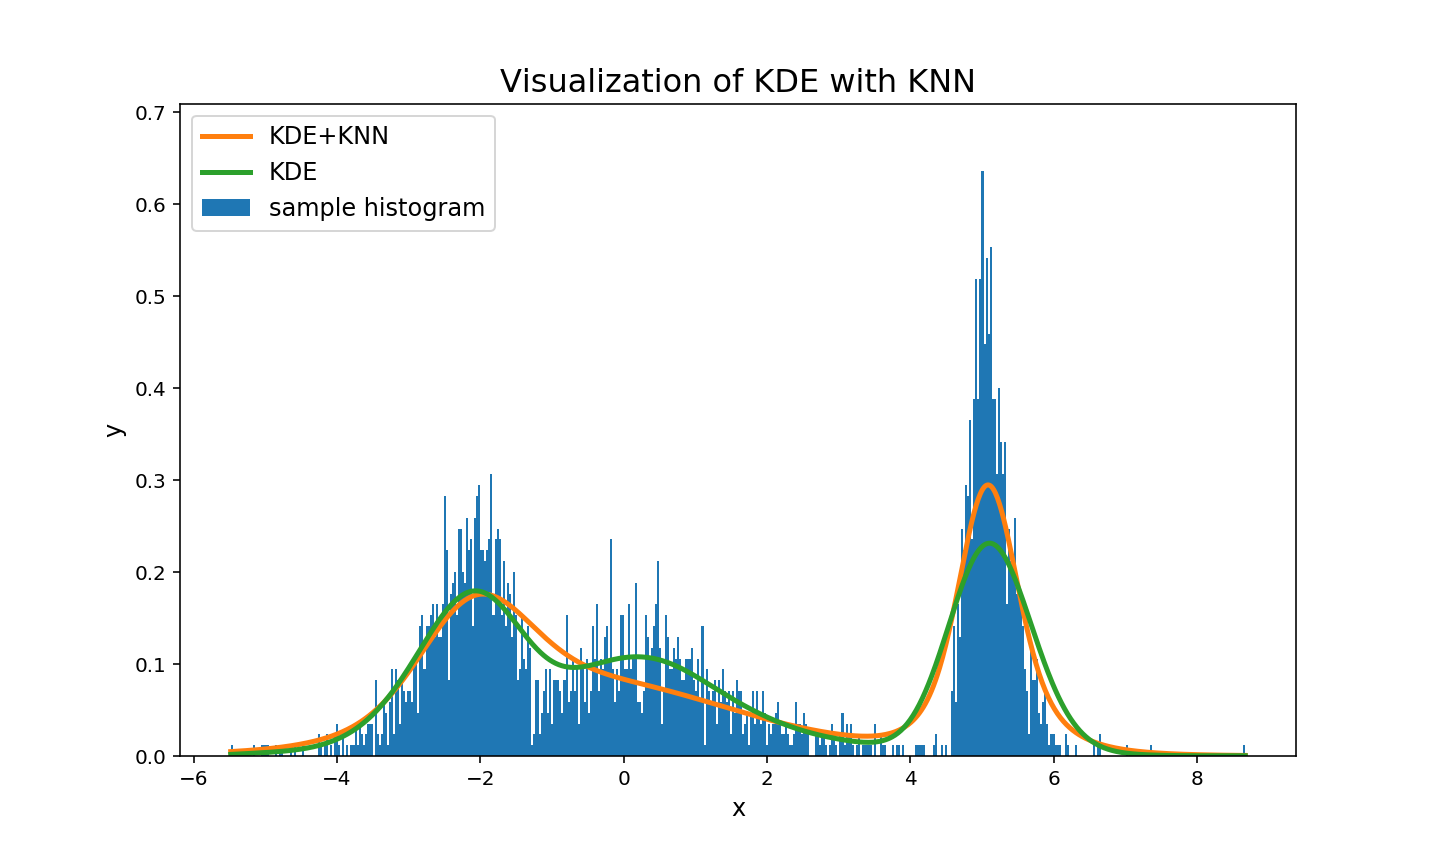

interactive(children=(IntSlider(value=750, description='neighb_num', max=1500), FloatSlider(value=0.5, descrip…

In [19]:
%matplotlib notebook

# plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data, density=True, bins=500, label='sample histogram')
line_kde_knn, = ax.plot(x, kde_with_knn(x, data, distances, 50),
                          label='KDE+KNN', linewidth=2.5)
line_kde, = ax.plot(x, kde(x, data, 1), 
                    label='KDE', linewidth=2.5)

def update(neighb_num, h):
    line_kde_knn.set_ydata(kde_with_knn(x, data, distances, neighb_num))
    line_kde.set_ydata(kde(x, data, h))
    
    fig.canvas.draw_idle()

ax.set_title('Visualization of KDE with KNN', fontsize=16)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
plt.legend(fontsize=12)
interact(update, neighb_num=(0, 1500, 1), h=(0.0001, 1, 0.0001));

### Conclusion

Here on the plot we can see that by increasing bandwidth h in "naive" KDE and increasing neighbor number we get more smooth density estimation of the given sample.

KDE with KNN is assumed to be more accurate, because it's bandwidth (distribution scaling coefficient) is different for each point and depends of number of points near it (the more points in the $\varepsilon$-area of given point, the closer will be the k-th nearest neighbour). 

As a disadvantage - higher computational comlexity.